In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, roc_auc_score, RocCurveDisplay, roc_curve
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc
import numpy as np
import pandas as pd
from IMPJ import DataProcessor
import random
import matplotlib.pyplot as plt
from os.path import basename, exists
import matplotlib as mpl


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')

In [2]:
#non log transformed
nonlogpath = '..\\Fermi-LAT Data\\fl_varranked_rm0.csv'

#log transformed
logpath = '..\\Fermi-LAT Data\\fl_logtransformed.csv'

data = pd.read_csv(nonlogpath, index_col=0)
logdata = pd.read_csv(logpath, index_col=0)


print(data.columns)
NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate='constant', solver='sgd', random_state=1, max_iter=10000)
BNN = BaggingClassifier(estimator=NN,n_estimators=10,bootstrap=True)

Index(['Signif_Avg', 'Pivot_Energy', 'Flux1000', 'Energy_Flux100',
       'PL_Flux_Density', 'PL_Index', 'LP_Flux_Density', 'LP_Index', 'LP_beta',
       'LP_SigCurv', 'LP_EPeak', 'PLEC_Flux_Density', 'PLEC_IndexS',
       'PLEC_ExpfactorS', 'PLEC_Exp_Index', 'PLEC_SigCurv', 'Npred',
       'Variability_Index', 'Frac_Variability', 'ASSOC_PROB_BAY',
       'Flux_Band_0', 'Flux_Band_1', 'Flux_Band_2', 'Flux_Band_3',
       'Flux_Band_4', 'Flux_Band_5', 'Flux_Band_6', 'Flux_Band_7',
       'nuFnu_Band_0', 'nuFnu_Band_1', 'nuFnu_Band_2', 'nuFnu_Band_3',
       'nuFnu_Band_4', 'nuFnu_Band_5', 'nuFnu_Band_6', 'nuFnu_Band_7',
       'Sqrt_TS_Band_2', 'Sqrt_TS_Band_3', 'Sqrt_TS_Band_4', 'Sqrt_TS_Band_5',
       'Flux_History_0', 'Flux_History_1', 'Flux_History_2', 'Flux_History_3',
       'Flux_History_4', 'Flux_History_5', 'Flux_History_6', 'Flux_History_7',
       'Sqrt_TS_History_0', 'Sqrt_TS_History_1', 'Sqrt_TS_History_2',
       'Sqrt_TS_History_3', 'Sqrt_TS_History_4', 'Sqrt_TS_History_

In [3]:
'''
col = 'LP_EPeak'
indices = data.index.values.tolist()

num = 5

values = np.zeros(num)
for i in range(0,num):
    values[i] = random.choice(indices)
print(values)
dp = DataProcessor()
data = dp.multipleimputation(data,col,values)
data.to_csv('mi_test.csv')'''

"\ncol = 'LP_EPeak'\nindices = data.index.values.tolist()\n\nnum = 5\n\nvalues = np.zeros(num)\nfor i in range(0,num):\n    values[i] = random.choice(indices)\nprint(values)\ndp = DataProcessor()\ndata = dp.multipleimputation(data,col,values)\ndata.to_csv('mi_test.csv')"

In [4]:

# Creating test and train data and Classifiers 

test_size = 0.3

dp = DataProcessor()
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
logX,logY = dp.choose_2_vars('CLASS1',logdata,1,2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=4) 
logx_train, logx_test, logy_train, logy_test = train_test_split(X, Y, test_size=test_size,random_state=4) 

# Define the pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', BNN)
])

# Fit the pipeline on the training data

pipeline.fit(x_train,y_train)
y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)

pipeline.fit(logx_train,logy_train)
logy_pred = pipeline.predict(logx_test)
logy_proba = pipeline.predict_proba(logx_test)


check1
check1


The Neural Network accuracy is 90.60240963855422
The Neural Network ROC AUC Scores are: 0.8908290312784694
The Neural Network's Weighted Average ROC AUC Score is: 0.8908290312784694
The Neural Network's Logarithmic Loss Score is: 3.3872348968086
The Neural Network F1 Score is: 0.8641114982578396
The Neural Network Confusion Matrix is:
[[252  15]
 [ 24 124]]


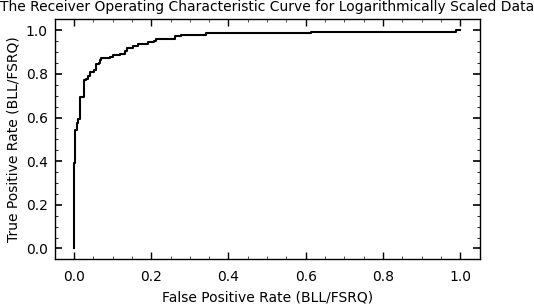

In [5]:
''' SCORING METRICS '''

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
roc_auc_weightedavg = roc_auc_score(y_test,y_pred,average='weighted')
logloss = log_loss(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_proba.T[1])

print('The Neural Network accuracy is ' + str(accuracy))
print('The Neural Network ROC AUC Scores are: '+str(roc_auc))
print("The Neural Network's Weighted Average ROC AUC Score is: " + str(roc_auc_weightedavg))
print("The Neural Network's Logarithmic Loss Score is: " + str(logloss))
print('The Neural Network F1 Score is: '+str(f1))
print('The Neural Network Confusion Matrix is:')
print(confusion)

mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(fpr,tpr)
ax.set_ylabel('True Positive Rate (BLL/FSRQ)')
ax.set_xlabel('False Positive Rate (BLL/FSRQ)')

#RocCurveDisplay.from_estimator(pipeline, x_test, y_test,ax=ax).figure_
plt.title('The Receiver Operating Characteristic Curve for Logarithmically Scaled Data')
plt.show()

In [6]:
# Saving the run to WandB

BNN_params = BNN.get_params
wandb.init(project='final-year-project', config=BNN_params)
wandb.config.update({"test_size" : test_size,
                    "train_len" : len(x_train),
                    "test_len" : len(x_test)})

plot_class_proportions(y_train, y_test, labels)
plot_learning_curve(BNN, x_train, y_train)
plot_roc(y_test, y_proba, labels)
plot_precision_recall(y_test, y_proba, labels)
#plot_feature_importances(model)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ioanpeakejones. Use `wandb login --relogin` to force relogin


NameError: name 'labels' is not defined

(415, 57)


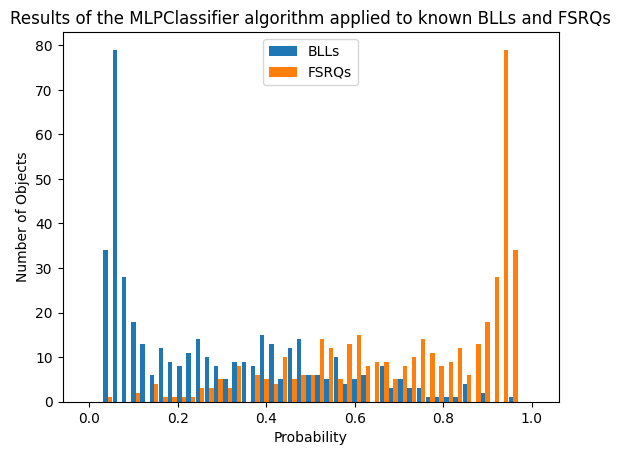

In [ ]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,50),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,50),include_lowest=True)

print(x_test.shape)

fig, ax = plt.subplots()
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.005,bin_probs_1.value_counts(sort=False), width=0.01,label='BLLs')
ax.bar(x_axis+0.005,bin_probs_2.value_counts(sort=False),width=0.01,label='FSRQs')
ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('Results of the MLPClassifier algorithm applied to known BLLs and FSRQs')

plt.show()